In [3]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

In [111]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_660.pth"
#checkpoint_path = "slurm/checkpoints/test_attention_config_spatial_T2m_U10m_2000_2014/test_attention_config_spatial_T2m_U10m_2000_2014_60.pth"

In [112]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

# Model with attention at the bottleneck
'''
TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [128,256,256,512],
'attention_levels' : [3],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }
'''

Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


'\nTRAIN_CONFIG = {\n    "epochs": 10000,\n    "batch_size": 5,\n    "learning_rate": 2e-4,\n    "weight_decay": 1e-4,\n    "scheduler": "cosine",\n    "embedding": 64,\n    "activation": "SiLU",\n    "eta": 5e-3,\n}\nMODEL_CONFIG = { \'hidden_channels\' : [128,256,256,512],\n\'attention_levels\' : [3],\n\'hidden_blocks\' : [2,3,3,3],\n\'spatial\' : 2,\n\'channels\' : channels,\n\'context\' : 4,\n\'embedding\' : 64 }\n'

In [113]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_660.pth, trained until epoch 660


/tmp/ipykernel_900946/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


<h3>Playgound</h3>

In [114]:
weather_station = (torch.rand(64,64) < 0.01) * mask_cpu
weather_station  = weather_station.to(device)

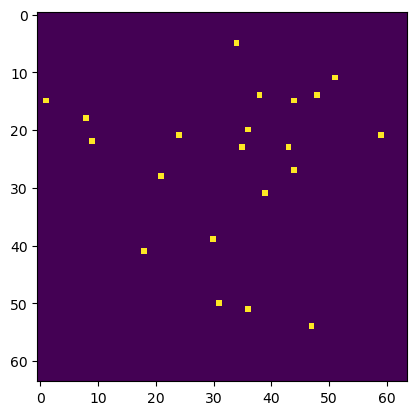

In [115]:
plt.imshow(weather_station[0].detach().cpu())
plt.show()

In [116]:
batch, dic = next(iter(testloader))
batch = batch.to(device)


In [117]:
sparsed_batch = batch * weather_station

torch.Size([5, 24, 64, 64])
T2m  Mean : 7.413370609283447, Var: 1.2576327323913574
U10m  Mean : 3.9623889923095703, Var: 1.412270426750183
T2m  Mean : 14.742986679077148, Var: 1.327230453491211
U10m  Mean : 5.798510551452637, Var: 1.4239102602005005
T2m  Mean : 12.257694244384766, Var: 0.9831374883651733
U10m  Mean : 4.95163106918335, Var: 1.547798752784729


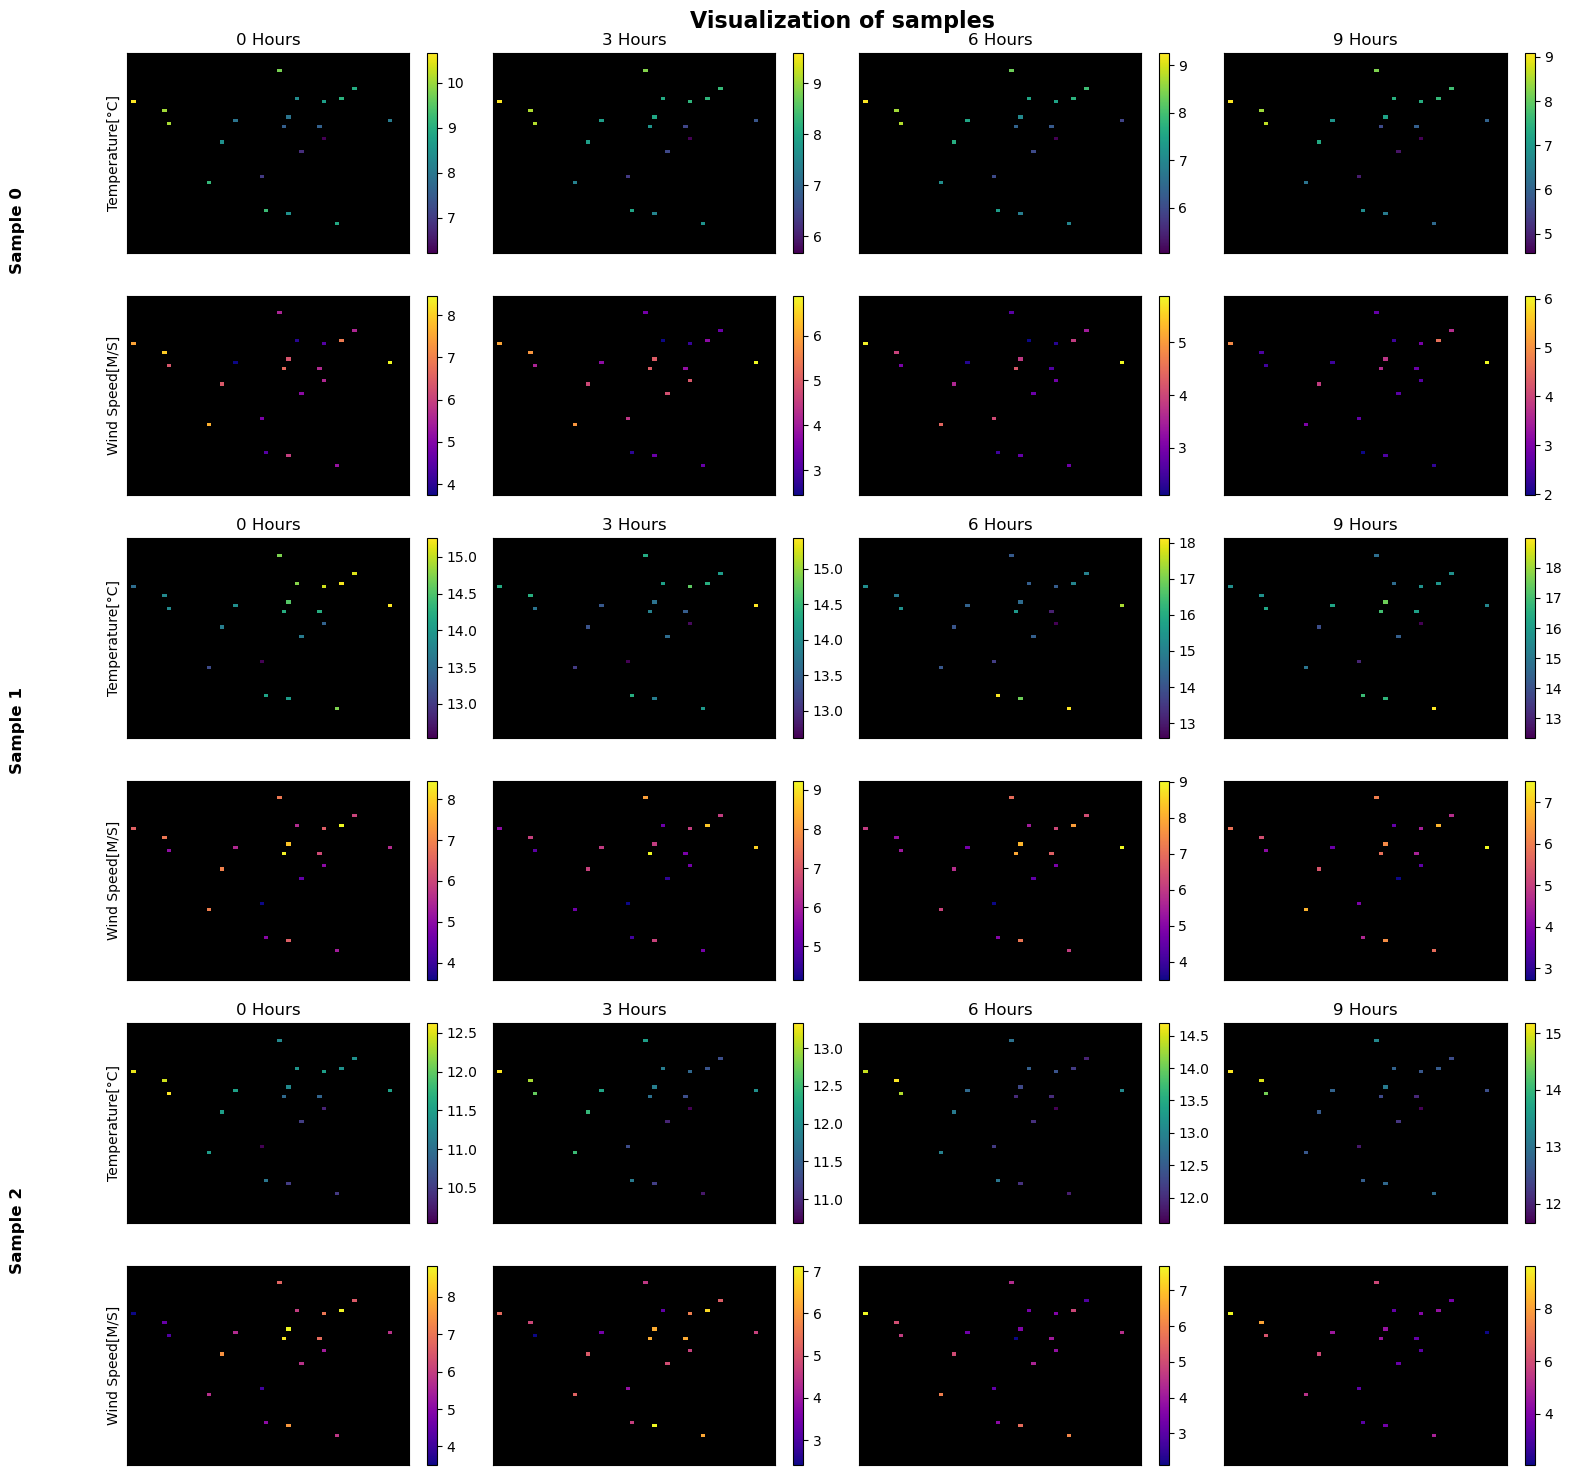

In [118]:
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sparsed_batch.cpu(),info,weather_station.cpu(),samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [119]:
def sparse_belgium(batch, mask):
    return batch*mask
def A(x):
    return sparse_belgium(x, weather_station)

torch.Size([5, 24, 64, 64])
T2m  Mean : 3.941033124923706, Var: 1.1151139736175537
U10m  Mean : 2.0912978649139404, Var: 0.8120579123497009
T2m  Mean : 8.617507934570312, Var: 2.320399522781372
U10m  Mean : 5.003436088562012, Var: 1.2451833486557007
T2m  Mean : 8.928383827209473, Var: 2.157994270324707
U10m  Mean : 3.3224196434020996, Var: 1.0403633117675781


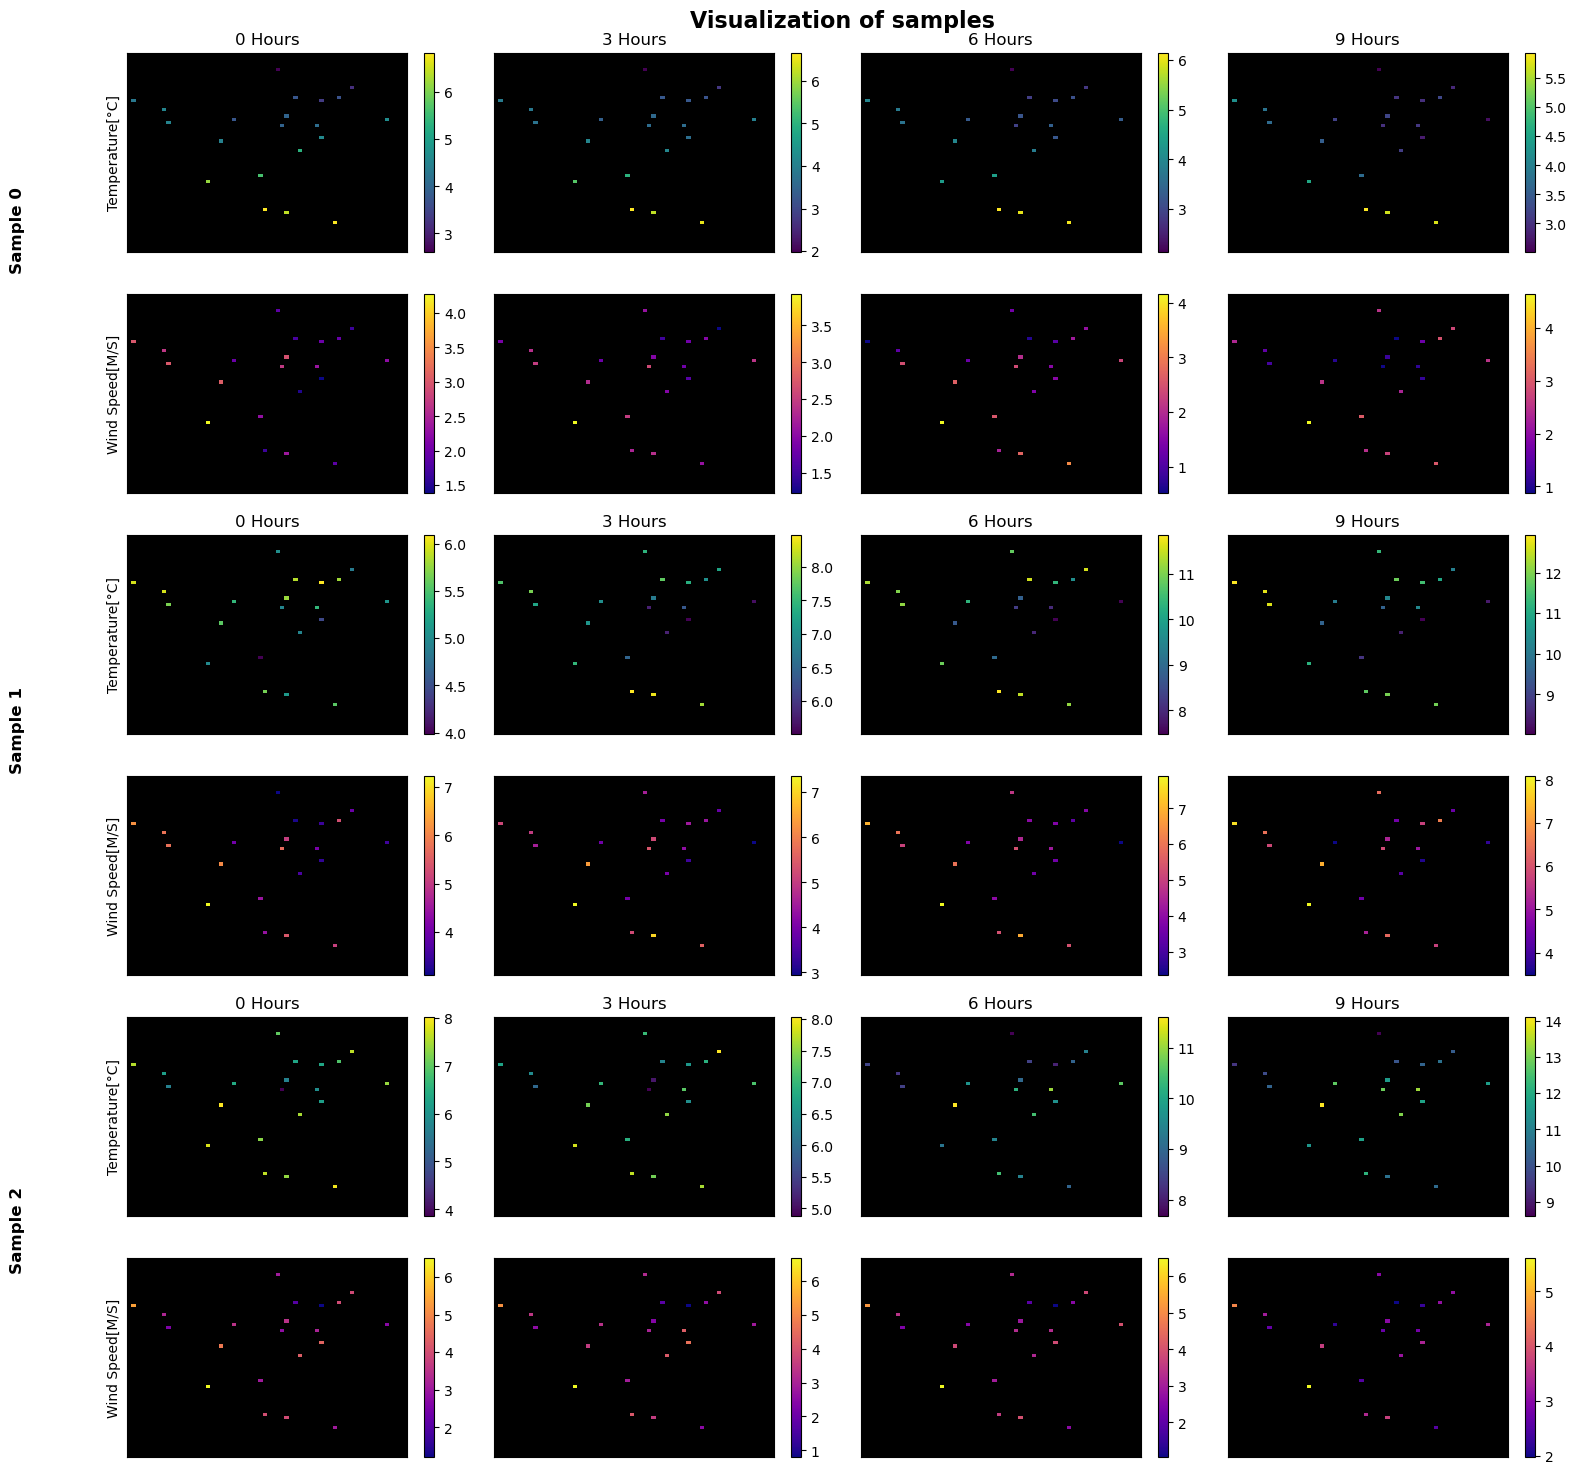

In [120]:
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(y_star.detach().cpu(),info,weather_station.detach().cpu(),samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [121]:
importlib.reload(score)
sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=11), shape=x_star.shape).cuda()

In [122]:
x = sde.sample(mask,shape=(1,), c=c_star, steps=64, corrections=8, tau=0.5).cpu()


100%|███████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.40it/s]


torch.Size([15, 24, 64, 64])
T2m  Mean : 3.9676859378814697, Var: 1.1488969326019287
U10m  Mean : 2.1751291751861572, Var: 0.8350961208343506
T2m  Mean : 10.341943740844727, Var: 0.5648399591445923
U10m  Mean : 3.9923179149627686, Var: 0.17941826581954956
T2m  Mean : 3.053494691848755, Var: 2.2953360080718994
U10m  Mean : 1.6936641931533813, Var: 0.9014375805854797
T2m  Mean : 8.398564338684082, Var: 2.3860321044921875
U10m  Mean : 5.059095859527588, Var: 1.2972067594528198
T2m  Mean : 10.376651763916016, Var: 0.26087936758995056
U10m  Mean : 4.013716697692871, Var: 0.1384725570678711
T2m  Mean : 8.73764705657959, Var: 1.279453992843628
U10m  Mean : 4.648366928100586, Var: 1.371188759803772
T2m  Mean : 8.74614143371582, Var: 1.9118508100509644
U10m  Mean : 3.26837420463562, Var: 1.2682908773422241
T2m  Mean : 10.37873363494873, Var: 0.23514629900455475
U10m  Mean : 4.001446723937988, Var: 0.108922578394413
T2m  Mean : 10.21568775177002, Var: 1.3924342393875122
U10m  Mean : 2.9258024692

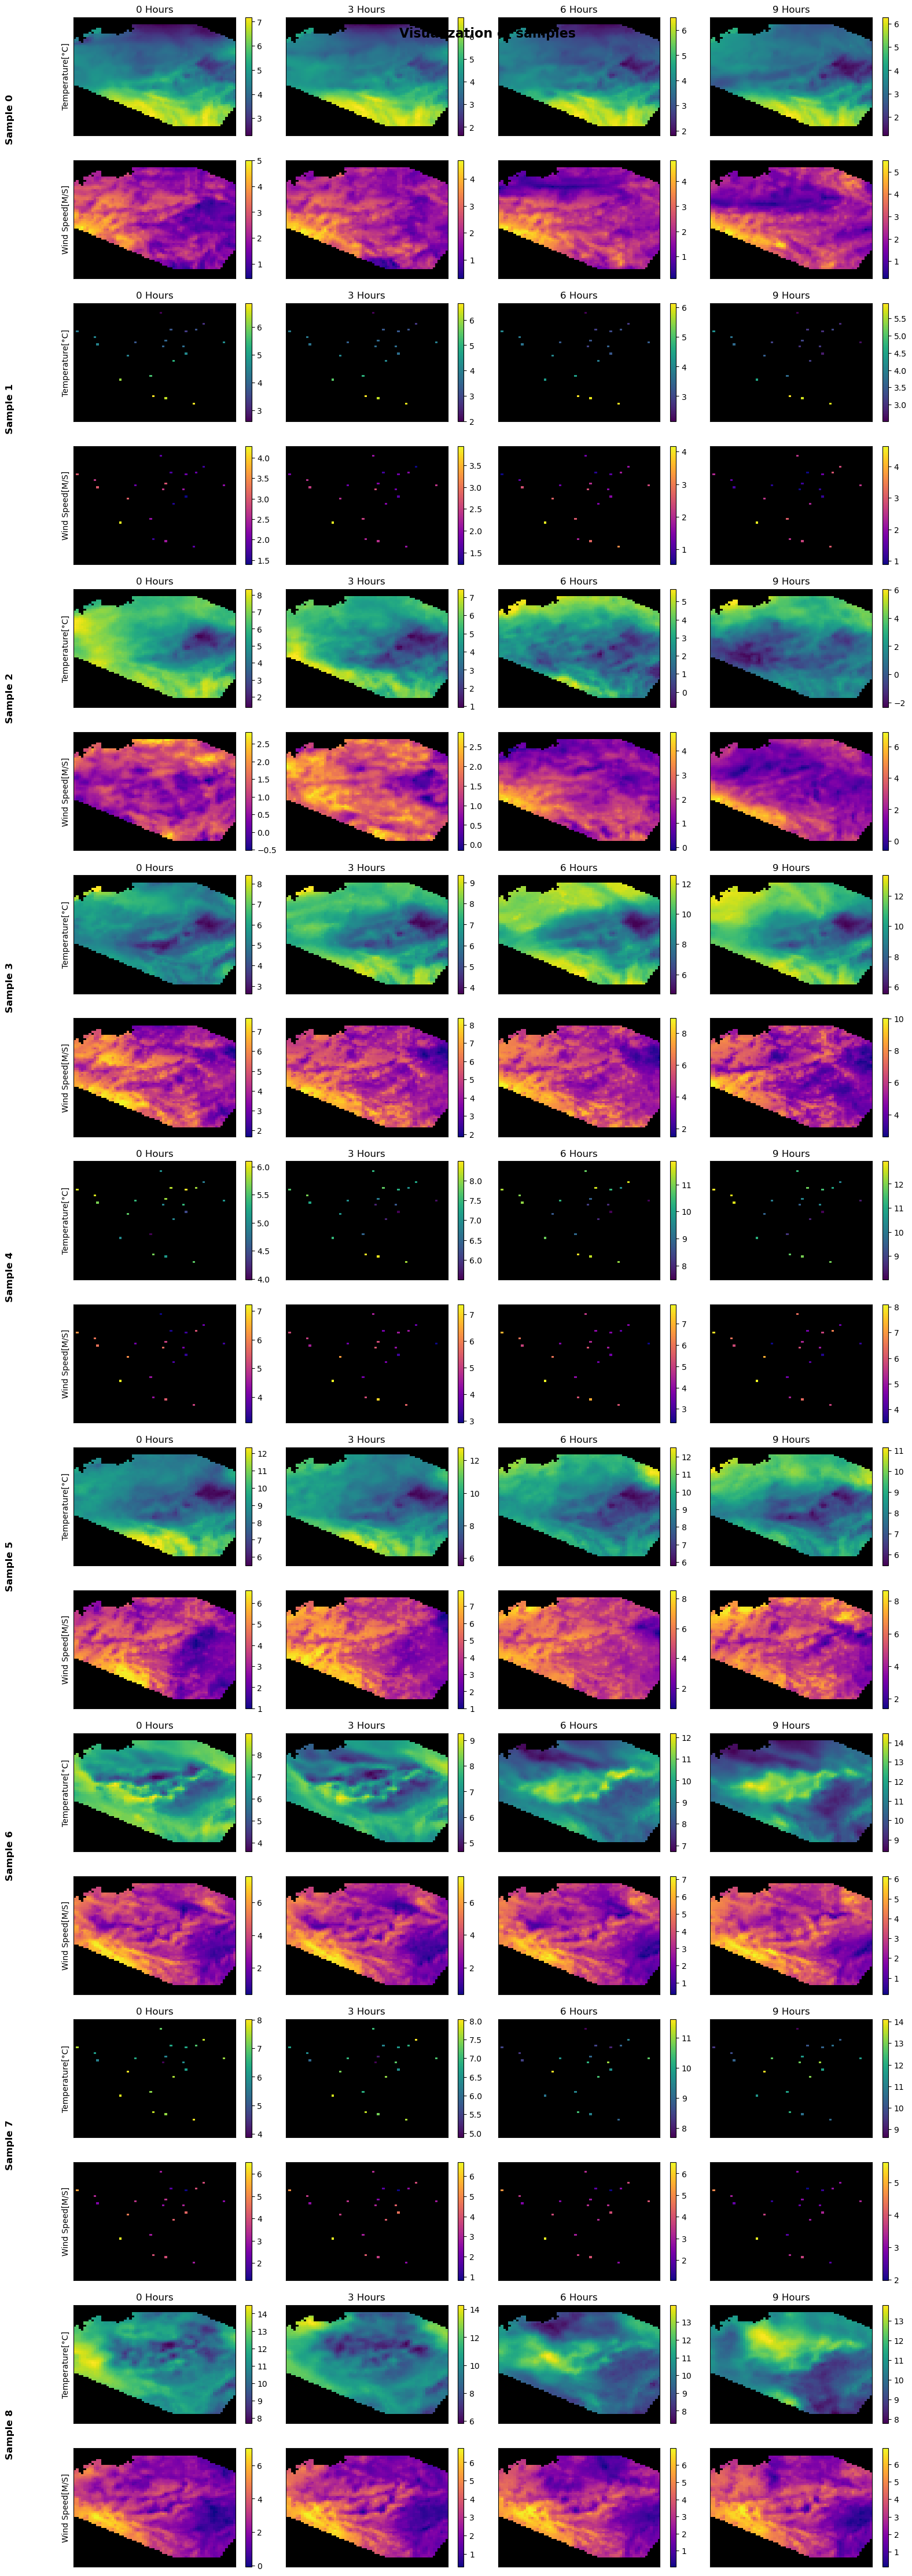

In [123]:
x_ = x[0]
# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# Good parameters : zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
# Nice parameters : p = 0.05 zeta = 25, steps = 64, corrections = 8
# For p = 0.01 : zeta = 11, steps = 64, corrections = 8
new_tensor = torch.stack((x_star.detach().cpu(),y_star.detach().cpu(),x_), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [24]:
def plot_sample(batch,info,mask, samples, step=4, unnormalize=True, path_unnorm = 'data/norm_params.h5'):
    print(batch.shape)
    B, Z, Y , X = batch.shape
    redim_batch = batch.view(B, info['window'], info['channels'], Y,X).permute(0, 2, 1, 3, 4)
    if unnormalize == True:
        for i in range(info['channels']):
            redim_batch[:,i, ...] = preprocess.unnormalize_ds(redim_batch[:,i, ...], info['var_index'][i], normfile_path=path_unnorm ,normalization_mode='zscore')
    traj= torch.where(mask.unsqueeze(0).unsqueeze(0).bool(), redim_batch, torch.tensor(float('nan'), dtype=redim_batch.dtype))
    data = traj
    s, variables, timesteps, y_dim, x_dim = data.shape
    selected_timesteps = range(0, timesteps, step)
    fig, axes = plt.subplots(nrows=info['channels'] * samples, ncols=len(selected_timesteps), figsize=(15, 5 * samples))
    cbar_axes = []
    for s in range(samples):
        for var in range(variables):
            mean, std =  np.nanmean(data[s,var,:]), np.nanstd(data[s,var,:])
            print(f"{info['var_index'][var]}  Mean : {mean}, Var: {std}")
            for i, t in enumerate(selected_timesteps):
                if ((s-1)%3) == 0:
                    data[s,var,t] = torch.where(weather_station.detach().cpu().bool(), data[s,var,t], torch.tensor(float('nan'), dtype=data[s,var,t].dtype))
                vmin, vmax = np.nanmin(data[s, var, t]), np.nanmax(data[s, var, t])
                ax = axes[info['channels'] * s + var, i]  # Correct row indexing
                img_data = data[s, var,t].numpy()
                img_data = np.ma.masked_invalid(img_data)
                cmap = plt.get_cmap('viridis' if var == 0 else 'plasma')
                cmap.set_bad(color='black')
                img = ax.imshow(img_data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
                ax.set_xticks([])
                ax.set_yticks([])
                if t == 0:
                    list_var = ["Temperature[°C]", "Wind Speed[M/S]"]
                    ax.set_ylabel(f'{list_var[var]}')
                if var == 0:
                    ax.set_title(f"{t} Hours")
                cbar_axes.append(fig.colorbar(img, ax=ax))

    for s in range(samples):
        fig.text(
            -0.05, 1 - (2 * s + 1) / (2 * samples),
            f"Sample {s}",
            va='center', ha='center', rotation=90, fontsize=12, fontweight='bold'
        )
    fig.suptitle("Visualization of samples", fontsize=16, fontweight="bold")
    plt.tight_layout()

    return fig